In [3]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from osprey.actions.forecaster import create_forecast_field

In [4]:
from osprey.actions.reader import reader_nemo_field

In [5]:
ds0 = reader_nemo_field(expname='pi00', startyear=1990, endyear=2040, varname='thetao')

2024-12-23 14:48:52,582 - INFO - Data available in the range 1990-2040.


In [6]:
from osprey.utils.time import get_decimal_year

In [3]:
import os
import numpy as np
import xarray as xr
import cftime

from osprey.utils.time import get_decimal_year
from osprey.means.eof import process_data
from osprey.utils import catalogue

varname='thetao'
endleg=21
tmp = "/ec/res4/scratch/itas/martini/TS00/021"

info = catalogue.observables('nemo')[varname]

def forecast_xarray(foreyear, use_cftime=True):
    """Get the xarray for the forecast time"""

    fdate = cftime.DatetimeGregorian(foreyear, 1, 16, 12, 0, 0, has_year_zero=False)

    if use_cftime == False:
        fdate = get_decimal_year([fdate])[0]
    
    xf = xr.DataArray(data = np.array([fdate]), dims = ['time'], coords = {'time': np.array([fdate])},
                      attrs = {'stardand_name': 'time', 'long_name': 'Time axis', 'bounds': 'time_counter_bnds', 'axis': 'T'})

    return xf

xf = forecast_xarray(2019, use_cftime=False)

filename = os.path.join(tmp, f"{varname}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True, preprocess=lambda data: process_data(data, ftype='pattern', dim=info['dim'], grid=info['grid']))
field = pattern.isel(time=0)*0

filename = os.path.join(tmp, f"{varname}_series_00000.nc")    
timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=lambda data: process_data(data, ftype='series', dim=info['dim'], grid=info['grid']))        
old_time = timeseries['time']
new_time = get_decimal_year(timeseries['time'].values)
timeseries['time'] = new_time
p = timeseries.polyfit(dim='time', deg=1, skipna = True)
m, q = p[f"{varname}_polyfit_coefficients"].values
print(f"m={m}, q={q}")
theta = xr.polyval(xf, p[f"{varname}_polyfit_coefficients"])
print(f"theta={theta.values}")
basis = pattern.isel(time=0)
field += theta * basis

m=-119.05976956553387, q=238660.359914224
theta=[-1726.37080141]


In [4]:
xf

<xarray.DataArray (time: 1)> Size: 8B
array([2019.04246575])
Coordinates:
  * time     (time) float64 8B 2.019e+03
Attributes:
    stardand_name:  time
    long_name:      Time axis
    bounds:         time_counter_bnds
    axis:           T

In [3]:
ds = create_forecast_field(expname='TS00', varname='thetao', endleg=21, yearspan=10, yearleap=10, mode='first', smoothing=False)

2024-12-23 14:53:09,049 - INFO - Start/end year: 2000-2009
2024-12-23 14:53:09,051 - INFO - Time window: 10
2024-12-23 14:53:09,056 - INFO - File /ec/res4/scratch/itas/martini/TS00/021/data.nc successfully removed.


/ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2000-2000.nc
/ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2001-2001.nc
/ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2002-2002.nc
/ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2003-2003.nc
/ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2004-2004.nc
/ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2005-2005.nc
/ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2006-2006.nc
/ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2007-2007.nc
/ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2008-2008.nc
/ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2009-2009.nc


2024-12-23 14:53:48,061 - INFO - Execution of cat finished.
2024-12-23 14:53:48,096 - INFO - File /ec/res4/scratch/itas/martini/TS00/021/thetao.nc successfully removed.
2024-12-23 14:54:08,384 - INFO - Execution of selname finished.
2024-12-23 14:54:08,397 - INFO - File /ec/res4/scratch/itas/martini/TS00/021/thetao_timmean.nc not found.
2024-12-23 14:54:11,608 - INFO - Execution of timmean finished.
2024-12-23 14:54:11,619 - INFO - Execution of merge finished.
2024-12-23 14:54:11,620 - INFO - File /ec/res4/scratch/itas/martini/TS00/021/thetao_anomaly.nc successfully removed.
2024-12-23 14:54:11,620 - INFO - Detrending variable thetao by subtracting the time average.
2024-12-23 14:54:15,411 - INFO - Execution of detrend finished.
2024-12-23 14:54:15,423 - INFO - File /ec/res4/scratch/itas/martini/TS00/021/thetao_variance.nc successfully removed.
2024-12-23 14:54:15,424 - INFO - File /ec/res4/scratch/itas/martini/TS00/021/thetao_pattern.nc successfully removed.
2024-12-23 14:54:15,424 - 

m=-119.05976956553387, q=238660.359914224
theta=[-1726.37080141]


2024-12-23 14:54:31,405 - INFO - File /ec/res4/scratch/itas/martini/TS00/021/thetao_proj.nc successfully removed.
2024-12-23 14:54:31,451 - INFO - Adding trend to thetao using /ec/res4/scratch/itas/martini/TS00/021/thetao.nc on /ec/res4/scratch/itas/martini/TS00/021/thetao_eof.nc.
2024-12-23 14:54:37,069 - INFO - Retrended forecast data created: /ec/res4/scratch/itas/martini/TS00/021/thetao_proj.nc
2024-12-23 14:54:37,140 - INFO - Execution of retrend finished.


In [4]:
ds

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 1, y_grid_T: 148, x_grid_T: 180, z: 31)
Coordinates:
  * time     (time) object 8B 2019-01-16 12:00:00
    lon      (y_grid_T, x_grid_T) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
    lat      (y_grid_T, x_grid_T) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
  * z        (z) float32 124B 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y_grid_T, x_grid_T
Data variables:
    thetao   (time, z, y_grid_T, x_grid_T) float64 7MB dask.array<chunksize=(1, 1, 148, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Dec 23 14:54:36 2024: cdo -O -s -add /ec/res4/scratch/i...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [3]:
ds1 = create_forecast_field(expname='TS01', varname='thetao', endleg=21, yearspan=10, yearleap=10, mode='full', smoothing=False)

2024-12-23 13:31:46,751 - INFO - Start/end year: 2000-2009
2024-12-23 13:31:46,753 - INFO - Time window: 10


/ec/res4/scratch/itas/ece4/TS01/output/nemo/TS01_oce_1m_T_2000-2000.nc
/ec/res4/scratch/itas/ece4/TS01/output/nemo/TS01_oce_1m_T_2001-2001.nc
/ec/res4/scratch/itas/ece4/TS01/output/nemo/TS01_oce_1m_T_2002-2002.nc
/ec/res4/scratch/itas/ece4/TS01/output/nemo/TS01_oce_1m_T_2003-2003.nc
/ec/res4/scratch/itas/ece4/TS01/output/nemo/TS01_oce_1m_T_2004-2004.nc
/ec/res4/scratch/itas/ece4/TS01/output/nemo/TS01_oce_1m_T_2005-2005.nc
/ec/res4/scratch/itas/ece4/TS01/output/nemo/TS01_oce_1m_T_2006-2006.nc
/ec/res4/scratch/itas/ece4/TS01/output/nemo/TS01_oce_1m_T_2007-2007.nc
/ec/res4/scratch/itas/ece4/TS01/output/nemo/TS01_oce_1m_T_2008-2008.nc
/ec/res4/scratch/itas/ece4/TS01/output/nemo/TS01_oce_1m_T_2009-2009.nc


2024-12-23 13:31:48,290 - INFO - File /ec/res4/scratch/itas/martini/TS01/021/data.nc successfully removed.
2024-12-23 13:32:26,903 - INFO - Execution of cat finished.
2024-12-23 13:32:26,929 - INFO - File /ec/res4/scratch/itas/martini/TS01/021/thetao.nc successfully removed.
2024-12-23 13:32:40,650 - INFO - Execution of selname finished.
2024-12-23 13:32:40,676 - INFO - File /ec/res4/scratch/itas/martini/TS01/021/thetao_timmean.nc not found.
2024-12-23 13:32:44,650 - INFO - Execution of timmean finished.
2024-12-23 13:32:44,686 - INFO - Execution of merge finished.
2024-12-23 13:32:44,693 - INFO - File /ec/res4/scratch/itas/martini/TS01/021/thetao_anomaly.nc successfully removed.
2024-12-23 13:32:44,693 - INFO - Detrending variable thetao by subtracting the time average.
2024-12-23 13:32:48,996 - INFO - Execution of detrend finished.
2024-12-23 13:32:49,025 - INFO - File /ec/res4/scratch/itas/martini/TS01/021/thetao_variance.nc successfully removed.
2024-12-23 13:32:49,026 - INFO - Fil

Text(0.5, 1.0, 'x,y,z = [117, 110, 14]')

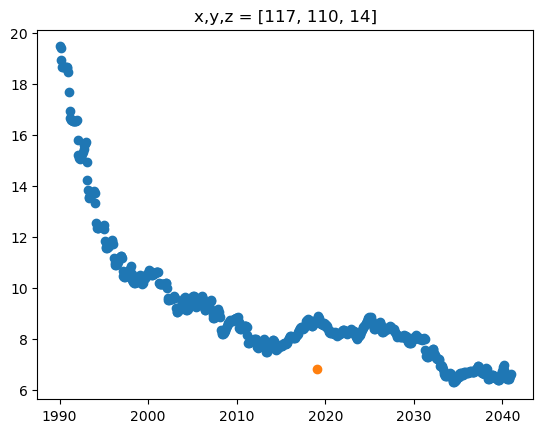

In [20]:
import random

x0=random.randint(0, 180)
y0=random.randint(0, 148)
z0=random.randint(0, 30)

yr = ds0.isel(z=z0,y=y0,x=x0).values
xr = get_decimal_year(ds0['time'].values)

xx = get_decimal_year(ds['time'].values)
yy = ds['thetao'].isel(time=0,z=z0,y_grid_T=y0,x_grid_T=x0).values

#xx1 = get_decimal_year(ds1['time'].values)
#yy1 = ds1['thetao'].isel(time=0,z=z0,y=y0,x=x0).values

plt.scatter(x=xr, y=yr)
plt.scatter(x=xx, y=yy)
#plt.scatter(x=xx1, y=yy1)
plt.title('x,y,z = {}'.format([x0,y0,z0]))

In [10]:
ds

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 1, y_grid_T: 148, x_grid_T: 180, z: 31)
Coordinates:
  * time     (time) float64 8B 0.0
    lon      (y_grid_T, x_grid_T) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
    lat      (y_grid_T, x_grid_T) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
  * z        (z) float32 124B 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y_grid_T, x_grid_T
Data variables:
    thetao   (time, z, y_grid_T, x_grid_T) float64 7MB dask.array<chunksize=(1, 1, 148, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Dec 23 13:31:38 2024: cdo -O -s -add /ec/res4/scratch/i...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

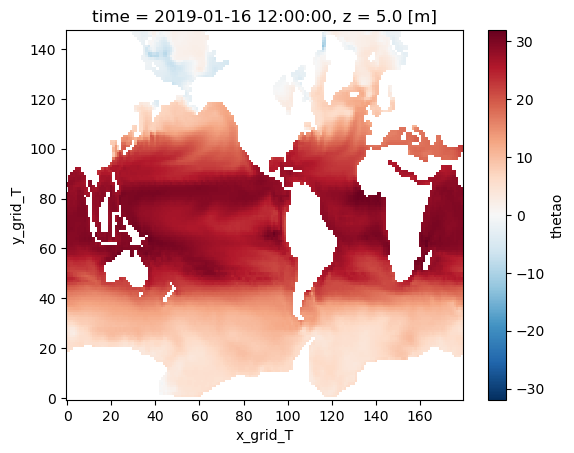

In [21]:
ds['thetao'].isel(time=0,z=0).plot()

In [22]:
delta = ds['thetao'].isel(time=0) - 0.5*(ds0.isel(time=347)+ds0.isel(time=348))
#delta1 = ds1['thetao'].isel(time=0) - 0.5*(ds0.isel(time=347)+ds0.isel(time=348))

: 

In [15]:
from osprey.means.means import spacemean

In [16]:
ave = spacemean(data=delta, ndim='3D')
#ave1 = spacemean(data=delta1, ndim='3D')

In [19]:
ave.values#,ave1.values

(array(-0.26531161), array(-0.2637392))

In [17]:
ave.values,ave1.values

(array(-0.24788055), array(-0.24466543))

In [1]:
delta.isel(z=0).plot(cmap=plt.cm.coolwarm)

NameError: name 'delta' is not defined

In [18]:
sqerr = delta**2
sqerr1 = delta1**2
mse = spacemean(data=sqerr, ndim='3D')
mse1 = spacemean(data=sqerr1, ndim='3D')
((mse)**0.5).values,((mse1)**0.5).values

(array(2.33773692), array(2.33462481))

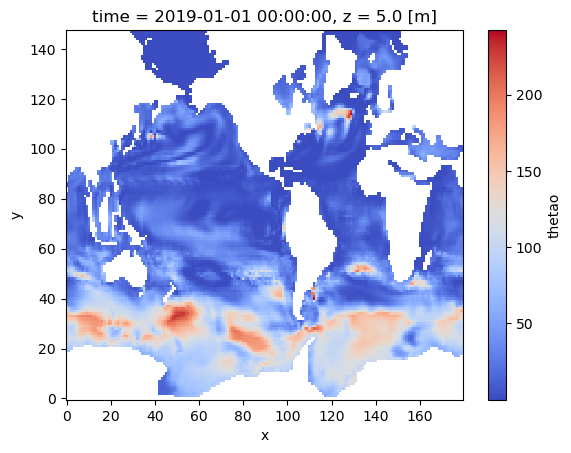

In [31]:
sqerr.isel(z=0).plot(cmap=plt.cm.coolwarm)

(array([2.0000e+00, 0.0000e+00, 4.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 5.0000e+00, 4.0000e+00, 6.0000e+00, 4.0000e+00,
        6.0000e+00, 1.3000e+01, 9.0000e+00, 4.7000e+01, 1.3800e+02,
        3.4100e+02, 8.2600e+02, 2.4630e+03, 5.4070e+03, 1.0820e+04,
        1.4535e+04, 1.8885e+04, 2.6421e+04, 3.5582e+04, 2.7671e+04,
        3.0038e+04, 2.4864e+04, 2.2006e+04, 1.9766e+04, 2.4518e+04,
        9.4776e+04, 2.5845e+04, 1.3739e+04, 1.0050e+04, 6.5290e+03,
        4.8400e+03, 3.5280e+03, 2.6520e+03, 1.7130e+03, 9.2700e+02,
        6.0200e+02, 4.1100e+02, 2.6000e+02, 1.4300e+02, 5.1000e+01,
        4.0000e+01, 3.0000e+01, 2.0000e+01, 4.0000e+00, 3.0000e+00]),
 array([-28.04404068, -27.12827563, -26.21251058, -25.29674553,
        -24.38098048, -23.46521543, -22.54945038, -21.63368533,
        -20.71792028, -19.80215523, -18.88639018, -17.97062513,
        -17.05486008, -16.13909504, -15.22332999, -14.30756494,
        -13.39179989, -12.47603484, -11.56026979, -10.64450474

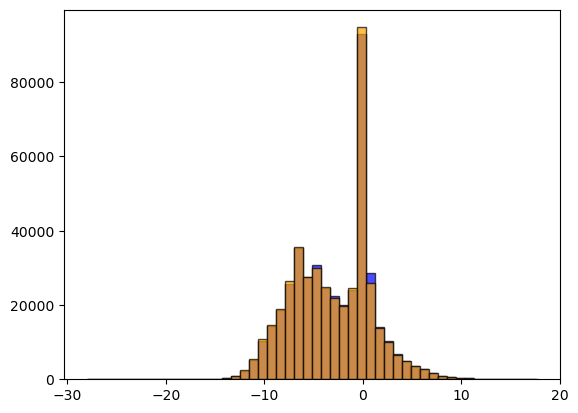

In [22]:
plt.hist(delta.values.flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.hist(delta1.values.flatten(), bins=50, color='orange', alpha=0.7, edgecolor='black')

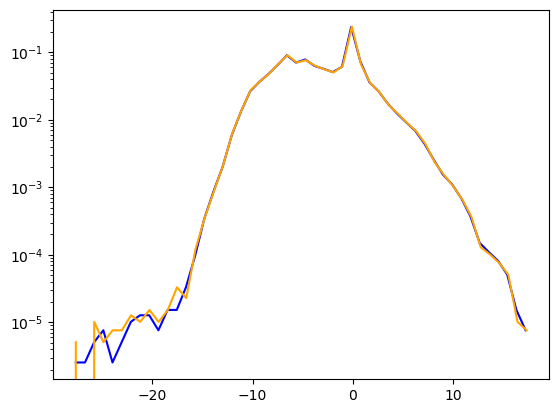

In [26]:
import numpy as np

flattened_delta = delta.values.flatten()
flattened_delta1 = delta1.values.flatten()

filtered_delta = flattened_delta[~np.isnan(flattened_delta) & ~np.isinf(flattened_delta)]
filtered_delta1 = flattened_delta1[~np.isnan(flattened_delta1) & ~np.isinf(flattened_delta1)]

density, bins = np.histogram(filtered_delta, bins=50, density=True)
density1, bins1 = np.histogram(filtered_delta1, bins=50, density=True)

bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_centers1 = 0.5 * (bins1[1:] + bins1[:-1])

plt.plot(bin_centers, density, label="full EOFs", color="blue")
plt.plot(bin_centers1, density1, label="first EOF", color="orange")
plt.yscale('log')

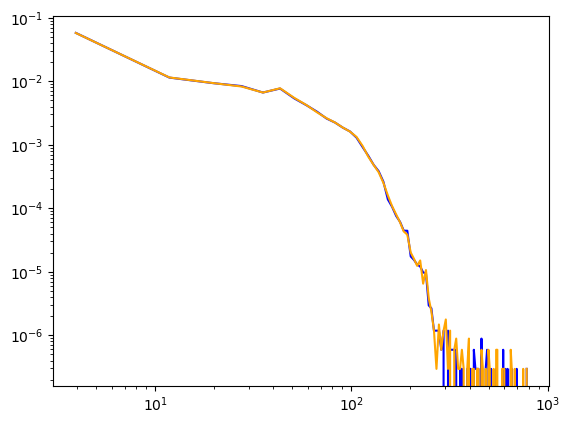

In [34]:
flattened_delta = sqerr.values.flatten()
flattened_delta1 = sqerr1.values.flatten()

filtered_delta = flattened_delta[~np.isnan(flattened_delta) & ~np.isinf(flattened_delta)]
filtered_delta1 = flattened_delta1[~np.isnan(flattened_delta1) & ~np.isinf(flattened_delta1)]

density, bins = np.histogram(filtered_delta, bins=100, density=True)
density1, bins1 = np.histogram(filtered_delta1, bins=100, density=True)

bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_centers1 = 0.5 * (bins1[1:] + bins1[:-1])

plt.plot(bin_centers, density, label="full EOFs", color="blue")
plt.plot(bin_centers1, density1, label="first EOF", color="orange")
plt.yscale('log')
plt.xscale('log')